
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

{'rnn_size': 400, 'tsteps': 4, 'batch_size': 5}
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
{'rnn_size': 400, 'tsteps': 4, 'batch_size': 5}
Saved {} lines 226
Number of data examples: 214
Batch size for dataset 107
[1000871. 1005748.       0.] [-1. 12.  0.] [-1. 12.  0.] [ 2. 24.  0.]


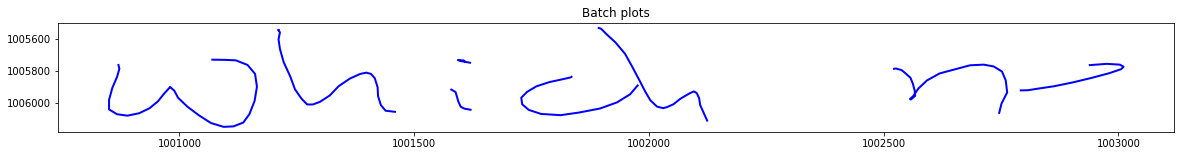

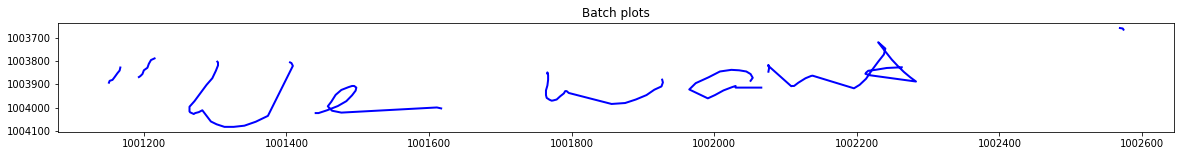

In [1]:
import numpy as np
import tensorflow as tf

import argparse
import time
import os


from LSTM import Model
import LSTM
from importlib import reload
reload(LSTM)
from dataloader import DataProcess

In [4]:
def init_args():
    
        args = {}
        args['rnn_size'] = 100 
        args['tsteps'] = 150 
        args['batch_size'] = 32 
        args['nmixtures'] = 8 
        args['alphabet'] = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        args['tsteps_per_ascii'] = 25
        args['epochs'] = 100
        return args
    
def train_model():
    sess = tf.Session()
    data_loader = DataProcess()
    args = init_args()
    print("blah")
    print(args)
    model = Model(args)
    for epoch in range(args['epochs']):
        if (epoch%5 == 0):
            print("Running epoch:", epoch)
        
        c0, c1, c2 = model.istate_cell0.c.eval(session=sess), model.istate_cell1.c.eval(session=sess), model.istate_cell2.c.eval(session=sess)
        h0, h1, h2 = model.istate_cell0.h.eval(session=sess), model.istate_cell1.h.eval(session=sess), model.istate_cell2.h.eval(session=sess)
        
        for bindex in range(args['batch_size']):
            i = epoch*args['batch_size'] + bindex
            start = time.time()
            x, y = data_loader.get_next_batch()
            y_placeholder = tf.placeholder(tf.float32, shape = [2, 150, 2])
            input_data = tf.placeholder(dtype=tf.float32, shape=[None, args['tsteps'], 3])
            feed = {input_data: x, y_placeholder: y, \
                    model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                    model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
            loss = 1000000
            inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(input_data, args['tsteps'], 1)]
            print(inputs[0])
            output0 = model.build_computational_graph(inputs, model.cell0, model.istate_cell0, "cell0")
            output0 = tf.convert_to_tensor(output0, dtype=tf.float32)
            logits = output0
            
            labels = y_placeholder
            print(logits.shape)
            print(labels.shape)
            with tf.name_scope("loss"):
                loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output0, labels=y_placeholder)    
            [train_loss, _] = sess.run([loss, model.optimizer], feed)    
            # print(len(inputs)) 
#             output = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, initial_cell_state, cell, loop_function=None, scope=scope)
            
            
#             out0 = sess.run(model.build_computational_graph(x_placeholder, model.cell0, model.istate_cell0, "cell0"), feed_dict = {x_placeholder:x})
#             # out1, final_state1 = model.build_computational_graph(out0, model.cell1, model.istate_cell1, "cell1")
#             # out2, final_state2 = model.build_computational_graph(out1, model.cell2, model.istate_cell2, "cell2")
#             [train_loss, _] = sess.run([loss, model.optimizer], feed)
#             print("train_loss:",train_loss, "Epoch:", epoch)
            
    

In [5]:
train_model()

Saved {} lines 226
Number of data examples: 214
Batch size for dataset 107
blah
{'rnn_size': 100, 'tsteps': 150, 'batch_size': 32, 'nmixtures': 8, 'alphabet': ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', 'tsteps_per_ascii': 25, 'epochs': 100}
{'rnn_size': 100, 'tsteps': 150, 'batch_size': 32, 'nmixtures': 8, 'alphabet': ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', 'tsteps_per_ascii': 25, 'epochs': 100}
Running epoch: 0
[1000605. 1002422.       0.] [ 6. 25.  0.] [ 6. 25.  0.] [ 3. 27.  0.]
Tensor("Squeeze_150:0", shape=(?, 3), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
(150, 32, 100)
(2, 150, 2)


ValueError: Rank mismatch: Rank of labels (received 3) should equal rank of logits minus 1 (received 3).